## D2L_08：线性回归的实现
这是d2l的08课的代码学习
[视频地址](https://www.bilibili.com/video/BV1PX4y1g7KC/)

In [152]:
import random
import torch
import matplotlib.pyplot as plt
#from d2l import torch as d2l

1. 准备数据

In [194]:
# 生成模拟数据  
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))
    y = torch.matmul(X, w) + b
    # 为了使数据更真实，加上一个随机干扰    
    y += torch.normal(0, 0.01, y.shape)
    return X, y.reshape(-1, 1)

true_w = torch.tensor([2.0, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
features.shape, labels.shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

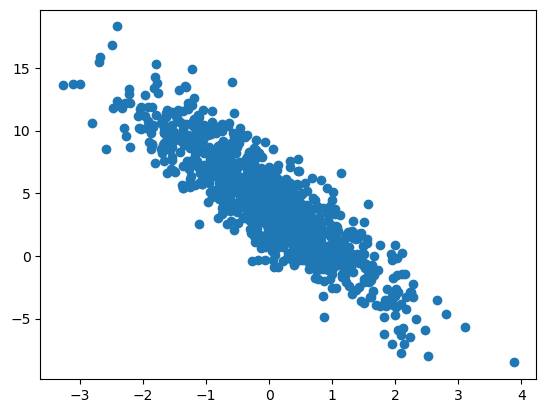

In [195]:
# y与x是线性关系的，由于w1的绝对值大，w1的线性强一些，所以x1与y的线性关系强一些
# 这里用散点图看一下y与x1的线性关系
# 某些版本需要调用tensor.detach()从计算图解绑tensor，才能转成ndayyay
plt.scatter(features[:, 1].numpy(), labels.numpy())
plt.show()

In [196]:
# 批量样本的生成器 每次调用next(g)，都会得到batch_size个数据
def data_iter(batch_size, features, labels):
    # 随机下样本索引     
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        start = i
        end = min(i + batch_size, num_examples)
        select = indices[start:end]
        yield features[select], labels[select]


2. 定义线性回归：即只有一层的神经网络

In [197]:
# 样本长度是2，输出是1，因此权重的形状是(2,1)
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# 定义线性回归的模型
def linreg(X, w, b):
    return torch.matmul(X, w) + b

# 损失函数，均方误差，一般来说直接y_hat - y即可  如果行列不同reshape一下就行，
def square_loss(y_hat, y):
    return sum((y_hat - y) ** 2) / 2


